# Opinion Mining & Sentiment Analysis: Deep Learning Techniques

**Text Mining unit**

_Prof. Gianluca Moro, Dott. Ing. Roberto Pasolini – DISI, University of Bologna_

**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Setup

Import external libraries (thus verifying they are correctly installed)

In [1]:
import gzip
import numpy as np
import pandas as pd
import gensim
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Define a utility function to download data files if they are not already present in working directory

In [2]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Deep Learning and Neural Networks for Text Mining and Sentiment Analysis

_Deep learning_ denotes a general approach to machine learning employing **multi-layered models** to obtain **accurate representation of input data**: features are no longer extracted manually, but infered in the learning process

DL is mostly based on _neural networks_, very flexible learning models with arbitrary complexity

The use of DL and NN allows deep understanding of text without manually defining rules, lexicons, etc.

## TensorFlow and Keras

- **TensorFlow** by Google is one of the most used computation frameworks for deep learning
  - TF works by building a _computational graph_ where each node represents an operation between _tensors_ (N-dimensional arrays)
    - sums, products, derivatives, ...
  - a graph can run either on CPU or (where available) on GPU for accelerated parallel computation
- **Keras** provides an high-level API for building and training neural networks using TensorFlow as a backend
  - networks can be built simply by stacking different layers with many configurable (hyper)parameters
  - high-level commands are provided to train and evaluate networks on given datasets

## Dataset: Movie Reviews

We have a collection of user reviews extracted from IMDb (the _Internet Movie Database_) labeled as positive or negative

We want to train a model to understand the positive or negative orientation of any review

We start by loading the training dataset, containing 25,000 samples with two attributes
- `label` indicates the orientation of the review, can be "pos" or "neg"
- `text` contains the full text of the review

In [ ]:
download("imdb-train.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/imdb-train.csv.gz")

In [3]:
train_set = pd.read_csv("imdb-train.csv.gz", sep="\t", names=["label", "text"])

In [4]:
train_set.shape

(25000, 2)

Let's view some rows of the dataset, after increasing the lenght of shown text

In [5]:
pd.options.display.max_colwidth = 100

In [6]:
train_set.head()

,label,text
0,pos,Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school l...
1,neg,Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a t...
2,pos,"If you like adult comedy cartoons, like South Park, then this is nearly a similar format about t..."
3,neg,Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so w...
4,pos,"Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this sea..."


Some HTML tags are present within reviews, specifically `<br />` to indicate newlines: we write a function which, applied on a text, replaces such tags with ASCII newline `\n`

In [7]:
def strip_tags(text):
    return text.replace("<br />", "\n")

We apply the function to all texts in the dataset

In [8]:
train_set["text"] = train_set["text"].apply(strip_tags)

Positive and negative reviews are evenly distributed

In [9]:
train_set["label"].value_counts()

neg    12500
pos    12500
Name: label, dtype: int64

## Multi-Layer Perceptron

In their usual form, neural networks are composed by a stack of _densely connected_ layers of nodes: each node in a layer receives the output of all nodes of the underlying layer. Such networks are also known as _multi-layer perceptrons_.

A MLP receives a vector as input and its topmost layer produces a vector as output, an arbitrary number of _hidden layers_ can be inserted inbetween to produce intermediate representations of data

Let's start by training a neural network for sentiment classification feeded with vector space model representations of reviews

We initialize a vector space using tf.idf term weighting and filtering out very rare terms

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=3)

Such vector space is built upon the training reviews and their document-term matrix is produced

In [11]:
train_dtm = vect.fit_transform(train_set["text"])

Similarly to training matrices for scikit-learn models, this is a 2D array where each row (1st axis) is a training observation and each column (2nd axis) is a feature: each row is a possible input to the neural network

We extract the number of distinct terms in the vector space, used to define the structure of the neural network

In [12]:
num_terms = len(vect.get_feature_names())

In [13]:
num_terms

35852

We want our neural network to indicate in output the correct class of each review, either "pos" or "neg"

The common approach to classification with neural networks is to have one output node for each class and train them to output 1 on the right node and 0 on the others

For this, we must extract from the `label` column a "target" matrix, where each row contains the values which the network should give as output for each review
- `[1, 0]` for positive reviews
- `[0, 1]` for negative reviews

We define a function `make_target` which converts a given pos/neg labels series into a target matrix

In [14]:
def make_target(labels):
    return pd.DataFrame({
        "pos": labels == "pos",
        "neg": labels == "neg"
    }).astype(int)

We then apply it to the training set labels

In [15]:
train_target = make_target(train_set["label"])

We obtain a matrix where each row is the expected network output, either `[1, 0]` (positive) or `[0, 1]` (negative)

In [16]:
train_target.head()

,pos,neg
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


Let's define the structure of the neural network

We create a _sequential_ model, i.e. we define the network as a sequence of interconnected layers (alternatively, we could create non-linear structures by manually connecting layers to each other)

In [17]:
from keras.models import Sequential
model = Sequential()

In this first example we create a single-layered network, where inputs are directly connected to the output nodes

As discussed above, the output nodes must be 2, one for each class; we use the _softmax_ activation function to ensure that the output is a valid probability distribution
- we will never get a perfect `[1, 0]` as output in practice, but we will get outputs like `[0.99, 0.01]`

In the first layer (in this case the only one) we also have to specify with `input_dim` the size of input vectors, in this case the number of terms in the vector space

In [18]:
from keras.layers import Dense
model.add(Dense(2, activation="softmax", input_dim=num_terms))

Instructions for updating:
Colocations handled automatically by placer.


With `summary` we can analyze the structure of our network and get the count of trainable parameters

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 71706     
Total params: 71,706
Trainable params: 71,706
Non-trainable params: 0
_________________________________________________________________


In this case we have 35,852×2 = 71,704 weights + 2 biases = 71,706 trainable parameters

After defining the network structure, we _compile_ it to provide some general settings of the network and initialize accordingly the underlying TensorFlow data structures

In [20]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

- The _optimizer_ is the algorithm used to train the network: _Adam_ and other valid options are different variants of stochastic gradient descent (SGD), including learning rate decay, momentum, etc.
- The _loss_ is the measure to be minimized in the training process: the _cross entropy_ penalizes outputs which are not close to 1 on the correct class
- Additional _metrics_ can be computed for evaluation purposes: we use the accuracy, i.e. the percentage of correctly classified examples

We are now ready to train (_fit_) the network on given training examples, composed of inputs (tf.idf vectors) and target outputs (`[1, 0]` for positive reviews and `[0, 1]` for negative)

The training examples are shuffled and used to run SGD steps on _minibatches_ of a specified size (`batch_size`): this process is repeated for a given number of training _epochs_

In [21]:
fit_history = model.fit(train_dtm, train_target, batch_size=200, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
25000/25000 [==============================] - 2s 99us/step - loss: 0.6565 - acc: 0.8006
Epoch 2/10
25000/25000 [==============================] - 2s 75us/step - loss: 0.5870 - acc: 0.8650
Epoch 3/10
25000/25000 [==============================] - 2s 72us/step - loss: 0.5327 - acc: 0.8776
Epoch 4/10
25000/25000 [==============================] - 2s 71us/step - loss: 0.4892 - acc: 0.8866
Epoch 5/10
25000/25000 [==============================] - 2s 72us/step - loss: 0.4534 - acc: 0.8933
Epoch 6/10
25000/25000 [==============================] - 2s 72us/step - loss: 0.4236 - acc: 0.8993
Epoch 7/10
25000/25000 [==============================] - 2s 72us/step - loss: 0.3982 - acc: 0.9060
Epoch 8/10
25000/25000 [==============================] - 2s 73us/step - loss: 0.3763 - acc: 0.9102
Epoch 9/10
25000/25000 [==============================] - 2s 72us/step - loss: 0.3571 - acc: 0.9157
Epoch 10/10
25000/25000 [===========================

During the training process we see how loss and accuracy measured on the training set vary, their evolution can also be obtained from the "history" object returned by `fit`

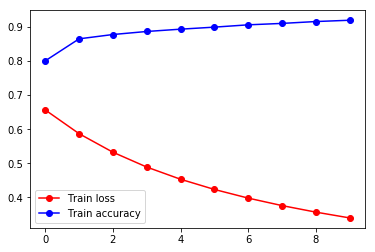

In [22]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["acc"], "bo-")
plt.legend(["Train loss", "Train accuracy"]);

We can see in the plot how the loss progressively decreases and accuracy progressively increases through training epochs

To get the raw output given by the network for a given input, we use the `predict` method: let's see for example the output for the first training review (labeled positive)

In [23]:
model.predict(train_dtm[0])

array([[0.6024959 , 0.39750406]], dtype=float32)

We see that the first class (positive) has higher probability

We can directly get the predicted class index with `predict_classes`

In [24]:
model.predict_classes(train_dtm[0])

array([0])

Let's now evaluate the network on a separate test set of labeled reviews, provided in the `imdb-test.csv.gz` file

In [ ]:
download("imdb-test.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/imdb-test.csv.gz")

In [25]:
test_set = pd.read_csv("imdb-test.csv.gz", sep="\t", names=["label", "text"])

In [26]:
test_set.head(5)

,label,text
0,pos,I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit ...
1,neg,Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the ter...
2,pos,"My boyfriend and I went to watch The Guardian.At first I didn't want to watch it, but I loved th..."
3,neg,This is a pale imitation of 'Officer and a Gentleman.' There is NO chemistry between Kutcher and...
4,pos,My yardstick for measuring a movie's watch-ability is if I get squirmy. If I start shifting posi...


Also in this dataset we have 25,000 reviews evenly distributed

In [27]:
test_set["label"].value_counts()

neg    12500
pos    12500
Name: label, dtype: int64

As before, we apply the HTML strip function to reviews

In [28]:
test_set["text"] = test_set["text"].apply(strip_tags)

We represent the test reviews in the vector space created on training reviews

In [29]:
test_dtm = vect.transform(test_set["text"])

We then convert pos/neg labels for test examples into target vectors

In [30]:
test_target = make_target(test_set["label"])

After processing the test set, we can fed it to the neural network for evaluation using the `evaluate` method

In [31]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 2s 85us/step


[0.39980619232177733, 0.87]

The method reports the loss (first value) and the accuracy (second value) measured on the given test set: our final goal is to maximize the accuracy

Let's now introduce a _hidden layer_ in the network between input and output, for example a layer of 128 nodes with linear activation which receive input vectors

In [32]:
model = Sequential()
model.add(Dense(128, input_dim=num_terms))

The output of these 128 will be fed to the output layer, composed as above by 2 nodes with softmax activation

In [33]:
model.add(Dense(2, activation="softmax"))

The number of network parameters to be trained is now much higher

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               4589184   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 4,589,442
Trainable params: 4,589,442
Non-trainable params: 0
_________________________________________________________________


Let's compile the network as before

In [35]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

To keep compute times limited, we fit this and subsequent networks running only 3 training epochs

In [36]:
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 8s 306us/step - loss: 0.4134 - acc: 0.8499
Epoch 2/3
25000/25000 [==============================] - 7s 291us/step - loss: 0.1654 - acc: 0.9444
Epoch 3/3
25000/25000 [==============================] - 7s 293us/step - loss: 0.0887 - acc: 0.9769


Let's evaluate this new network on the same test set as before

In [37]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 3s 138us/step


[0.32061737238645555, 0.87064]

Thanks to the hidden layer we had a very slight improvement, despite the lower number of training epochs

To make the model more expressive, we have to introduce non-linearity in hidden layers: for example, we replicate the model above using sigmoid activation in the hidden layer

We can create the model more concisely by provinding the list of layers to be stacked

In [38]:
model = Sequential([
    Dense(128, activation="sigmoid", input_dim=num_terms),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [39]:
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 8s 305us/step - loss: 0.6447 - acc: 0.7328
Epoch 2/3
25000/25000 [==============================] - 7s 285us/step - loss: 0.4856 - acc: 0.8792
Epoch 3/3
25000/25000 [==============================] - 7s 286us/step - loss: 0.3455 - acc: 0.9050


In [40]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 3s 134us/step


[0.35995052280426026, 0.87292]

Finally, let's test a deep model with three non-linear hidden layers

In [41]:
model = Sequential([
    Dense(256, activation="sigmoid", input_dim=num_terms),
    Dense(64, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               9178368   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 9,195,890
Trainable params: 9,195,890
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 13s 517us/step - loss: 0.6805 - acc: 0.5889
Epoch 2/3
25000/25000 [==============================] - 12s 493us/step - loss: 0.4331 - acc: 0.8516
Epoch 3/3
25000/25000 [==============================] - 12s 487us/step - loss: 0.1986 - acc: 0.9298


In [44]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 177us/step


[0.27334151494503023, 0.88668]

## Word Embedding

A _word embedding_ model is a dictionary mapping each known word to a **N-dimensional vector**

Such model is built by training a neural network on a bunch of text to predict the most likely word in a context defined by other words
- training is unsupervised: no labeling of text is needed

The resulting vector of each word somehow denotes its meaning: **semantically similar words are represented with similar vectors**. Moreover, operations between vectors can be used to **find words semantically related** to each other.

Word embedding models can be used to represent text in NLP tasks, including sentiment analysis

The **gensim** library provides means to represent and build word embedding models

## Training a Word2Vec model

We have a set of 5,000 movie reviews without any labeling: we can't train a sentiment classifier on them but we can train a word embedding model

We read the compressed text file `imdb-unsup-5k.txt.gz`, containing one review per line

In [ ]:
download("imdb-unsup-5k.txt.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/imdb-unsup-5k.txt.gz")

In [45]:
with gzip.open("imdb-unsup-5k.txt.gz", "rt") as f:
    we_train_set = [strip_tags(line.strip()) for line in f]

We have to preprocess each review by splitting text into tokens

gensim, the library used to train the word embedding model, provides a simple utility function for this
- alternatively any tokenization function can be used, e.g. `nltk.word_tokenize`

In [46]:
from gensim.utils import simple_preprocess

In [47]:
%%time
we_train_tokens = [simple_preprocess(text) for text in we_train_set]

CPU times: user 1.1 s, sys: 4 ms, total: 1.1 s
Wall time: 1.11 s


In [48]:
we_train_set[0][:82]

'I admit, the great majority of films released before say 1933 are just not for me.'

In [49]:
we_train_tokens[0][:8]

['admit', 'the', 'great', 'majority', 'of', 'films', 'released', 'before']

We can now use the token sequences to train the Word2Vec embedding model

The most important parameter is the size of the word vectors we want to obtain
- in the original Word2Vec paper 300 is indicated as a good value
- here we use 50 as a tradeoff between accuracy and efficiency

In [50]:
wordvecs_size = 50

Other relevant parameters are
- the _window size_, i.e. the number of words before and after any word to consider as its context
- the minimum appearances of a term to be included in the model

We specify these options in the `Word2Vec` initializer, together with the set of token sequences used to train the model

In [51]:
%%time
wv_model = gensim.models.Word2Vec(
    we_train_tokens,
    size=wordvecs_size,
    window=5,
    min_count=5
)

CPU times: user 6.3 s, sys: 0 ns, total: 6.3 s
Wall time: 6.3 s


Our Word2Vec model is now trained, we can get a reference to the word->vector mapping itself `wv` and drop the rest of the model object to free some memory

In [52]:
wv = wv_model.wv
del wv_model

## Exploring the word embedding model

How many distinct terms are represented in the model?

In [53]:
len(wv.vocab)

12070

Which are these terms? `index2word` is an ordered list with more common terms coming first

In [54]:
wv.index2word[:10]

['the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'that', 'as']

Let's see the vector of a word, e.g. "excellent"

In [55]:
wv.word_vec("excellent")

array([-0.5114084 , -0.7340342 ,  1.0234174 ,  0.22948086,  0.5712674 ,
        0.37628934,  0.64706683, -1.487537  ,  0.28225353, -0.8491546 ,
        0.9058341 , -0.1314533 ,  0.43188205,  0.50562024,  1.7984192 ,
        0.38935652, -1.2059857 ,  1.6213577 , -0.663144  , -0.6638046 ,
       -0.7816187 ,  0.32186472,  1.6609577 , -0.71841544,  0.487278  ,
       -0.941309  , -0.09710978, -0.79371464, -0.76231325, -0.01406466,
        2.067998  ,  0.20384946,  2.089359  ,  0.526346  ,  0.817104  ,
        0.12727872, -1.4547936 , -0.1885227 ,  0.05824345,  0.82262087,
        1.2286468 ,  1.108042  , -0.6305742 ,  0.27894366,  2.622213  ,
       -0.36938676,  1.0290797 ,  0.49994272,  1.2949158 ,  1.2688118 ],
      dtype=float32)

We can also compute and get normalized word vectors, used to compute cosine similarity

In [56]:
wv.init_sims()   # compute and cache normalized vectors

In [57]:
# True indicates to normalize the vector
wv.word_vec("excellent", True)

array([-0.07301285, -0.10479673,  0.14611144,  0.03276256,  0.08155882,
        0.05372215,  0.09238056, -0.21237296,  0.04029683, -0.12123226,
        0.12932429, -0.01876735,  0.06165902,  0.07218648,  0.25675705,
        0.05558772, -0.17217639,  0.23147829, -0.09467586, -0.09477018,
       -0.11159029,  0.04595204,  0.23713192, -0.10256687,  0.0695678 ,
       -0.13438897, -0.01386419, -0.1133172 , -0.10883408, -0.00200799,
        0.2952443 ,  0.02910322,  0.298294  ,  0.07514547,  0.11665645,
        0.01817135, -0.20769824, -0.02691504,  0.00831531,  0.11744409,
        0.17541167,  0.15819314, -0.09002594,  0.03982428,  0.37436858,
       -0.05273668,  0.14691983,  0.07137591,  0.18487278,  0.18114597],
      dtype=float32)

The word vector by itself doesn't give much information, but we can search for example which are the words with vectors most similar to this...

Let's use the `cosine_similarities` function to compute similarity between this vector and all the other ones, stored in the `vector` array

In [58]:
similarities_to_excellent = wv.cosine_similarities(
    wv.word_vec("excellent"),
    wv.vectors
)

We obtain an array of cosine similarity scores

In [59]:
similarities_to_excellent[:5]

array([ 0.07619354,  0.28495064,  0.11302141, -0.1732213 ,  0.24119678],
      dtype=float32)

Let's label them with the term they refer to and sort by descending values

In [60]:
pd.Series(
    similarities_to_excellent,
    wv.index2word
).sort_values(ascending=False).head(10)

excellent         1.000000
outstanding       0.916733
fine              0.894400
brilliant         0.893838
superb            0.886434
amazing           0.865420
cinematography    0.858674
impressive        0.856665
beautifully       0.856412
stunning          0.855289
dtype: float32

In this way we found **other words** other than "excellent" with a **strong positive connotation**!

For this the model provides a `most_similar` method, which also removes the reference word from the results

In [61]:
wv.most_similar("excellent")

[('outstanding', 0.9167332053184509),
 ('fine', 0.8944001197814941),
 ('brilliant', 0.8938385248184204),
 ('superb', 0.8864337205886841),
 ('amazing', 0.8654204607009888),
 ('cinematography', 0.8586739897727966),
 ('impressive', 0.8566656112670898),
 ('beautifully', 0.8564115762710571),
 ('stunning', 0.8552893400192261),
 ('direction', 0.8523515462875366)]

We can similarly see what happens with a strongly negative word, e.g. "terrible"

In [62]:
wv.most_similar("terrible")

[('horrible', 0.9518212080001831),
 ('scary', 0.911191999912262),
 ('totally', 0.9069154262542725),
 ('hilarious', 0.9064745903015137),
 ('awful', 0.8990105390548706),
 ('ok', 0.887744665145874),
 ('predictable', 0.8807995319366455),
 ('boring', 0.8789013028144836),
 ('disappointing', 0.8723584413528442),
 ('weird', 0.8680090308189392)]

Other strongly negative words are found!

Another powerful function of word embedding models is to find words with specific syntactic and semantic relationships using vector arithmetics

Consider the relationship _"man" is to "woman" as "actor" is to X_ where the model has to find out that X = "actress"

Word2Vec produces vectors in such a way that _"man" - "woman" = "actor" - X_, so we can find X as the term whose vector is closest to _"actor" + "woman" - "men"_

Let's produce the vector representation of X...

In [63]:
composition = (wv.word_vec("actor", True)
             + wv.word_vec("woman", True)
             - wv.word_vec("man", True))

...and then find the words most similar to this composition

In [64]:
pd.Series(
    wv.cosine_similarities(composition, wv.vectors),
    wv.index2word
).sort_values(ascending=False).head(10)

actor          0.924466
actress        0.883101
role           0.849532
performance    0.803194
star           0.788036
lead           0.781273
villain        0.776565
effeminate     0.768296
oscar          0.762393
talented       0.757082
dtype: float32

Also in this case we can use `most_similar`, distinguishing words with positive and negative weight

In [65]:
wv.most_similar(
    positive=["actor", "woman"],
    negative=["man"]
)

[('actress', 0.8831006288528442),
 ('role', 0.8495315909385681),
 ('performance', 0.8031936883926392),
 ('star', 0.7880364656448364),
 ('lead', 0.7812731266021729),
 ('villain', 0.7765644788742065),
 ('effeminate', 0.7682958245277405),
 ('oscar', 0.7623934745788574),
 ('talented', 0.7570821046829224),
 ('chaney', 0.7563522458076477)]

According to randomness in the training process, the correct answer "actress" might be the most similar word or very close to it, but still the confidence of the model is limited

We proceed our analysis on a pretrained GloVe (_Global Vectors_) word embedding model, whose training procedure is similar to Word2Vec

We use a version trimmed down to the most common 100,000 terms of the 100d model trained on Wikipedia, available here: https://nlp.stanford.edu/projects/glove/

Arrays with words and vectors are provided in the `glove.npz` file

In [ ]:
download("glove.npz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/glove.npz")

In [66]:
with np.load("glove.npz") as f:
    glove_words = f["words"]
    glove_vectors = f["vectors"]

We read the vector size from the loaded array

In [67]:
wordvecs_size = glove_vectors.shape[1]
wordvecs_size

100

We then create the word embedding model from the words

In [68]:
wv = gensim.models.KeyedVectors(wordvecs_size)
wv[glove_words.tolist()] = glove_vectors
wv.init_sims()

Searching on this model for the answer to _man : woman = actor : X_...

In [69]:
wv.most_similar(
    positive=["actor", "woman"],
    negative=["man"]
)

[('actress', 0.9073609113693237),
 ('comedian', 0.6890829801559448),
 ('actresses', 0.6826434135437012),
 ('screenwriter', 0.6554961204528809),
 ('starred', 0.6533135175704956),
 ('starring', 0.6514241695404053),
 ('actors', 0.6402772068977356),
 ('dancer', 0.6378583908081055),
 ('singer', 0.6346279382705688),
 ('filmmaker', 0.6279778480529785)]

...the correct answer "actress" is more dominant on the other ones

Other examples with multiple pairs: finding the plural of a singular word...

In [70]:
wv.most_similar(
    positive=["mouse", "dogs", "cats"],
    negative=[         "dog",  "cat"]
)

[('mice', 0.710668683052063),
 ('rabbits', 0.681904673576355),
 ('rodents', 0.6771590709686279),
 ('rats', 0.6427716016769409),
 ('animals', 0.6243681907653809),
 ('monkeys', 0.6002902984619141),
 ('ferrets', 0.5910987854003906),
 ('mammals', 0.5888075828552246),
 ('foxes', 0.5750464200973511),
 ('raccoons', 0.5635854005813599)]

...and finding the capital of a State

In [71]:
wv.most_similar(
    positive=["france", "rome",  "berlin"],
    negative=[          "italy", "germany"]
)

[('paris', 0.7584174275398254),
 ('cairo', 0.6146870851516724),
 ('london', 0.5959091186523438),
 ('versailles', 0.5937519669532776),
 ('vienna', 0.5896108150482178),
 ('brussels', 0.5775601863861084),
 ('petersburg', 0.5704914331436157),
 ('palace', 0.5681281089782715),
 ('sorbonne', 0.5556104183197021),
 ('strasbourg', 0.5552983283996582)]

Another method provided by the model is `doesnt_match` finding the word which is the least related to the others in a given list

In [72]:
wv.doesnt_match(["cat", "mouse", "dog", "keyboard", "frog"])

/home/rrobby/software/miniconda3/envs/dltutorial/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'keyboard'

## Representing text with word embedding

We now see how to leverage the word embedding model in a neural network for sentiment classification

We start by tokenizing texts of training reviews

In [73]:
%%time
train_tokens = [gensim.utils.simple_preprocess(text) for text in train_set["text"]]

CPU times: user 5.19 s, sys: 64 ms, total: 5.26 s
Wall time: 5.26 s


Let's see an example of tokenized review

In [74]:
train_set["text"][0][:34]

'Bromwell High is a cartoon comedy.'

In [75]:
train_tokens[0][:5]

['bromwell', 'high', 'is', 'cartoon', 'comedy']

We now convert these lists of text tokens into lists of indices of terms in the word embedding model, leaving out terms not present in the model

In [76]:
train_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in train_tokens
]

For example the begin of the review above is now represented with...

In [77]:
train_indices[0][:5]

[152, 14, 7362, 2841, 20]

...which translated back into words would be... (notice that the first term was removed because not in the embedding model)

In [78]:
[wv.index2word[i] for i in train_indices[0][:5]]

['high', 'is', 'cartoon', 'comedy', 'it']

As a first solution, we represent each review with the mean of normalized vectors of words contained in it: we obtain such vectors for all train reviews and stack them together in a matrix

In [79]:
train_we_repr = np.vstack([wv.vectors_norm[indices].mean(0) for indices in train_indices])

We then create a MLP network with one hidden layer accepting such vectors in input

In [80]:
model = Sequential([
    Dense(128, activation="sigmoid", input_dim=wordvecs_size),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

As the input size of the network is much lower, so it is the number of parameters

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
_________________________________________________________________


Training is much faster than before, so we can increment the epochs and reduce the batch size, thus making more SGD steps in each epoch

In [82]:
model.fit(train_we_repr, train_target, batch_size=20, epochs=10)

Epoch 1/10
25000/25000 [==============================] - 2s 70us/step - loss: 0.6513 - acc: 0.6361
Epoch 2/10
25000/25000 [==============================] - 1s 52us/step - loss: 0.5685 - acc: 0.7256
Epoch 3/10
25000/25000 [==============================] - 1s 52us/step - loss: 0.5178 - acc: 0.7570
Epoch 4/10
25000/25000 [==============================] - 1s 52us/step - loss: 0.4918 - acc: 0.7719
Epoch 5/10
25000/25000 [==============================] - 1s 52us/step - loss: 0.4772 - acc: 0.7798
Epoch 6/10
25000/25000 [==============================] - 1s 53us/step - loss: 0.4693 - acc: 0.7808
Epoch 7/10
25000/25000 [==============================] - 1s 52us/step - loss: 0.4645 - acc: 0.7875
Epoch 8/10
25000/25000 [==============================] - 1s 54us/step - loss: 0.4608 - acc: 0.7864
Epoch 9/10
25000/25000 [==============================] - 1s 55us/step - loss: 0.4584 - acc: 0.7889
Epoch 10/10
25000/25000 [==============================] - 1s 54us/step - loss: 0.4549 - acc: 0.7902

Let's preprocess test reviews as we did for training ones, thus extracting tokens and converting them to indices...

In [83]:
test_tokens = [gensim.utils.simple_preprocess(text) for text in test_set["text"]]
test_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in test_tokens
]

...and obtaining means of word vectors for each review

In [84]:
test_we_repr = np.vstack([wv.vectors_norm[indices].mean(0) for indices in test_indices])

We can now evaluate the network on the test reviews

In [85]:
model.evaluate(test_we_repr, test_target)

25000/25000 [==============================] - 0s 19us/step


[0.45890153659820554, 0.78648]

The accuracy is not as good as before: with this representation we lose identity of the words in the documents other than their order

## Recurrent neural networks

MLPs are _feed-forward_ networks: their output at any time is only dependent from their input at the same time

On the other side, if we somehow introduce **memory** inside a network, we can make its output dependent from current as well as past inputs, thus we can process **sequential data**

_Recurrent_ neural networks include **cyclic connections** between nodes, making the output dependent from the state of the network at previous time steps and thus from previous inputs

### Sequential data

While an input example for a MLP must be represented with a vector of size S, an example for a recurrent NN is represented with a **sequence of vectors**, fed to the network in T subsequent time steps (T is equal for all examples)

Thus N input samples with input size S are no longer represented with a N×S array, but with a N×T×S array

Leveraging the word embedding model, we represent each review with the **sequence of word vectors** for the terms contained in it
- in this way, we consider both the identity of words (the vectors) and their order!

We start from the sequences of word indices `*_indices` extracted above

We need to make all sequences of the same length (the T term above): we set a desired sequence size T, then we trim longer sequences to that size (taking the final T elements) and pad shorter sequences with null values: Keras' `pad_sequences` function does this
- larger T values would make training much slower

In [86]:
from keras.preprocessing.sequence import pad_sequences
max_words = 200
train_seq = pad_sequences(train_indices, max_words)

In [87]:
train_seq

array([[    0,     0,     0, ...,    12,    20, 75360],
       [    0,     0,     0, ...,    30,   541,  3442],
       [    0,     0,     0, ...,   219,   191,   219],
       ...,
       [    0,     0,     0, ..., 29080,  1075,    48],
       [  460,     4,    30, ...,   227,    30,  4254],
       [    0,     0,     0, ...,  1666,    13, 13664]], dtype=int32)

The size of the matrix is the number of samples times the sequence length, i.e. N×T

In [88]:
train_seq.shape

(25000, 200)

### Building the network

Let's now create a neural network which gets such sequences as input

In [118]:
model = Sequential()

We first insert an `Embedding` layer, which translates each received value into the word vector from the embedding model

We need to specify the size of input and output and the word vectors to be used, taking them from the model; we also specify `trainable=False` to "freeze" our pretrained word vectors and exclude them from training

In [119]:
from keras.layers import Embedding
model.add(Embedding(
    input_dim=len(wv.vocab),    # number of distinct vocabulary terms
    output_dim=wordvecs_size,   # size of word vectors (S)
    input_length=max_words,     # length of sequences (T)
    weights=[wv.vectors],       # word vectors
    trainable=False
))

The output of this layer is a N×T×S tensor, we feed it to a recurrent layer which receives S-sized vectors for T time steps

_Gated Recurrent Units_ (GRU) are a simplified version of _Long Short-Term Memory_ (LSTM) units, which can potentially hold information in memory across many time steps; we use here a layer of 128 GRU cells

_Dropout_ randomly drops (sets to zero) a given ratio of input values at each time step: it is a technique to prevent model overfitting

In [120]:
from keras.layers import GRU
model.add(GRU(128, dropout=0.2))

While producing 128 output values at each time step, the GRU layer by default only returns the outputs at the final steps, i.e. when the whole input sequence has been fed to the network, thus the output size of this layer is N×128 (the time dimension collapses)

We can now finalize the network with the output layer, which receives the output of the GRU layer

In [121]:
model.add(Dense(2, activation="softmax"))

The model summary gives a recap of shapes of data across network layers other than parameters

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          10000000  
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 10,088,194
Trainable params: 88,194
Non-trainable params: 10,000,000
_________________________________________________________________


We can now compile the network and train it on the padded sequences of word indices
- training of RNNs is quite slow, we again limit training to 3 epochs

In [123]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_seq, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 34s 1ms/step - loss: 0.6063 - acc: 0.6547
Epoch 2/3
25000/25000 [==============================] - 31s 1ms/step - loss: 0.4394 - acc: 0.7986
Epoch 3/3
25000/25000 [==============================] - 32s 1ms/step - loss: 0.3776 - acc: 0.8341


Let's now obtain the padded sequences also for the test reviews...

In [96]:
test_seq = pad_sequences(test_indices, max_words)

...and use them to evaluate the model

In [124]:
model.evaluate(test_seq, test_target)

25000/25000 [==============================] - 23s 910us/step


[0.34696731271743775, 0.8466]

## Cross domain classification

We trained our network on reviews of movies and tested its ability to classify sentiment in reviews of movies

Can we successfully apply our model to reviews pertaining to a different domain?

The `yelp-test-10k.csv.gz` file contains 10,000 labeled user reviews about restaurants extracted from Yelp

In [ ]:
download("yelp-test-10k.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/yelp-test-10k.csv.gz")

In [125]:
xdom_set = pd.read_csv("yelp-test-10k.csv.gz", sep="\t", names=["label", "text"])

In [126]:
xdom_set.head(5)

,label,text
0,pos,My wife took me here on my birthday for breakfast and it was excellent. The weather was perfec...
1,neg,U can go there n check the car out. If u wanna buy 1 there? That's wrong move! If u even want a...
2,pos,"I have no idea why some people give bad reviews about this place. It goes to show you, you can ..."
3,neg,Disgusting! Had a Groupon so my daughter and I tried it out. Very outdated and gaudy 80's sty...
4,pos,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of..."


In [127]:
xdom_set["label"].value_counts()

pos    5000
neg    5000
Name: label, dtype: int64

We apply the same preprocessing steps we applied above

In [128]:
xdom_set["text"] = xdom_set["text"].apply(strip_tags)
xdom_tokens = [gensim.utils.simple_preprocess(text) for text in xdom_set["text"]]
xdom_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in xdom_tokens
]
xdom_seq = pad_sequences(xdom_indices, max_words)
xdom_target = make_target(xdom_set["label"])

In [129]:
model.evaluate(xdom_seq, xdom_target)

10000/10000 [==============================] - 9s 872us/step


[0.3380804895401001, 0.8523]

The network is fairly accurate, although it was trained on reviews of a different domain

Can we further improve this?

## Fine tuning the network

In the `yelp-train-2k.csv.gz` we have a set of 2,000 labeled Yelp reviews which can be used for training

We would like to make use of these in-domain reviews, without throwing away the model trained on the richer set of cross-domain reviews

We can "tune" the trained model with an additional training run on the new set of reviews, thus making it more oriented to the new domain and still using knowledge from the other

Let's load and view a summary of the file...

In [ ]:
download("yelp-train-2k.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/yelp-train-2k.csv.gz")

In [130]:
tune_set = pd.read_csv("yelp-train-2k.csv.gz", sep="\t", names=["label", "text"])

In [131]:
tune_set.head(5)

,label,text
0,pos,Great local yoga studio. Had flexible hours like early morning and late night to fit any schedu...
1,neg,"I've been craving a good roast beef sandwich for a few days now, and finally had the chance to ..."
2,pos,"Super tasty, love the cozy atmosphere, excellent and friendly service! The naan was a bit thin..."
3,neg,"After waiting 4 days to get an appointment, Flores was a no show and didn't even bother to call."
4,pos,I have had my kitty Miller for 8 years. She has never been to any other vet. I like this place...


In [132]:
tune_set["label"].value_counts()

neg    1000
pos    1000
Name: label, dtype: int64

...and apply the usual preprocessing steps

In [133]:
tune_set["text"] = tune_set["text"].apply(strip_tags)
tune_tokens = [gensim.utils.simple_preprocess(text) for text in tune_set["text"]]
tune_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in tune_tokens
]
tune_seq = pad_sequences(tune_indices, max_words)
tune_target = make_target(tune_set["label"])

We now repeat the model training process on this set of reviews: the process is very fast due to the limited size of the dataset

In [134]:
model.fit(tune_seq, tune_target, epochs=5, batch_size=200)

Epoch 1/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3427 - acc: 0.8525
Epoch 2/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3033 - acc: 0.8735
Epoch 3/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2647 - acc: 0.8940
Epoch 4/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2344 - acc: 0.9085
Epoch 5/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.2100 - acc: 0.9175


Let's now repeat the evaluation on the Yelp test set loaded before

In [135]:
model.evaluate(xdom_seq, xdom_target)

10000/10000 [==============================] - 9s 858us/step


[0.20322929101586343, 0.9178]

We successfully boosted the model accuracy, combining even limited knowledge of the target domain with large knowledge extracted from a different domain